## **Homework**
**2.将 Chart Generator 替换为其他功能智能体（如 table_generator），为其设计提示词，然后运行查看生成结果。**

In [1]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"


### **1.辅助函数：创建智能体**

In [2]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


### **2.定义工具**

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### **3.辅助函数：智能体节点**

In [4]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

### **为 Agent 配置各自的大模型**

In [5]:
research_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
# chart_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
table_llm = ChatOpenAI(model="gpt-4o",temperature=0)

### **4. 定义 研究智能体及其节点**

In [6]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="Before using the search engine, carefully think through and clarify the query. "
    "Then, conduct a single search that addresses all aspects of the query in one go.",  # 系统消息，指导智能体如何使用搜索工具
)

# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### **5. 定义 table generator生成器智能体及其节点**

##### **5. 定义 图表生成器智能体及其节点**
```python
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Create clear and user-friendly charts based on the provided data.",  # 系统消息，指导智能体如何生成图表
)

# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")
```

In [7]:
table_agent = create_agent(
    table_llm, # 使用table_llm作为表格智能体的语言模型
    [python_repl],# 表格生成器智能体使用Python REPL工具
    system_message="Create clear and user-friendly tables based on the provided data.", # 系统消息，指导智能体如何生成表格         
)
# 使用functools.partial 创建表生成器智能体的节点指定改节点名称为"table_generator"
table_node = functools.partial(agent_node,agent=table_agent,name="table_generator")

### **6. 导入预构建的工具节点**

In [8]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

### **7. 建立智能体节点间通信 AgentState**

In [9]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str

### **8. 定义工作流（状态图）**

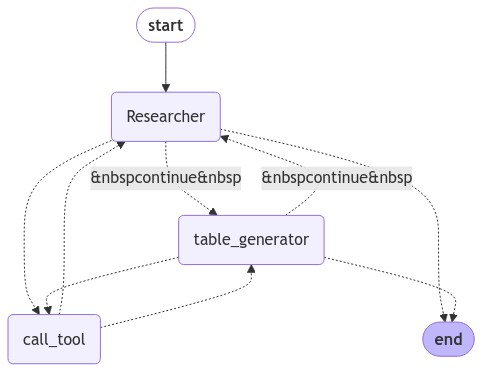

In [10]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
# workflow.add_node("Chart Generator", chart_node)
workflow.add_node("table_generator",table_node)
workflow.add_node("call_tool", tool_node)

# 定义路由函数
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"

# 定义条件边逻辑
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
       # "continue": "Chart Generator",  # 如果 router 返回 "continue"，则传递到 Chart Generator
        "continue":"table_generator",# 如果router返回"continue"，则传递到table_generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart Generator" 智能体节点添加条件边
# 为"table_generator"智能体节点添加条件边
workflow.add_conditional_edges(
   # "Chart Generator",
    "table_generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
       # "Chart Generator": "Chart Generator",  # 如果 sender 是 Chart Generator，则返回给 Chart Generator
        "table_generator":"table_generator",# 如果sender 是 table_generator,则返回给table_generator
    },
)
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

### **9. 执行工作流**

In [11]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then plot a markdown table with Python. End the task after generating the table。"
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then plot a markdown table with Python. End the task after generating the table。
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_2pW7rPINW7ifH9QwhpiZV4CC)
 Call ID: call_2pW7rPINW7ifH9QwhpiZV4CC
  Args:
    query: United States GDP data from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.statista.com/topics/772/gdp/", "content": "U.S. gross domestic product contributions 2000-2021, by sector\nValue added to gross domestic product across economic sectors in the United States from 2000 to 2021 (as a share of GDP)\nU.S. change in real value added to GDP 2022, by industry\nChange in real value added to the gross domestic product of the United States in 20

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: table_generator
Tool Calls:
  python_repl (call_1Spf17kEWljb43kvZpTqpe7y)
 Call ID: call_1Spf17kEWljb43kvZpTqpe7y
  Args:
    code: # Markdown table for US GDP from 2000 to 2020
gdp_data = {
    "Year": [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
             2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    "GDP (in billions)": [10258.1, 10582.0, 10580.4, 10655.4, 11000.0, 
                          11307.2, 11694.0, 12036.0, 12157.0, 12132.0, 
                          14582.0, 15094.0, 15518.0, 16078.0, 16784.0, 
                          17368.0, 17947.0, 18569.0, 19485.0, 21433.0, 
                          21058.0]
}

# Print the markdown table
print("| Year | GDP (in billions) |")
print("|------|--------------------|")
for year, gdp in zip(gdp_data["Year"], gdp_data["GDP (in billions)"]):
    print(f"| {year} | {gdp} |")
================================= T

#### **手动生成table**

In [13]:
# Markdown table for US GDP from 2000 to 2020
gdp_data = {
    "Year": [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
             2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    "GDP (in billions)": [10258.1, 10582.0, 10580.4, 10655.4, 11000.0, 
                          11307.2, 11694.0, 12036.0, 12157.0, 12132.0, 
                          14582.0, 15094.0, 15518.0, 16078.0, 16784.0, 
                          17368.0, 17947.0, 18569.0, 19485.0, 21433.0, 
                          21058.0]
}

# Print the markdown table
print("| Year | GDP (in billions) |")
print("|------|--------------------|")
for year, gdp in zip(gdp_data["Year"], gdp_data["GDP (in billions)"]):
    print(f"| {year} | {gdp} |")

| Year | GDP (in billions) |
|------|--------------------|
| 2000 | 10258.1 |
| 2001 | 10582.0 |
| 2002 | 10580.4 |
| 2003 | 10655.4 |
| 2004 | 11000.0 |
| 2005 | 11307.2 |
| 2006 | 11694.0 |
| 2007 | 12036.0 |
| 2008 | 12157.0 |
| 2009 | 12132.0 |
| 2010 | 14582.0 |
| 2011 | 15094.0 |
| 2012 | 15518.0 |
| 2013 | 16078.0 |
| 2014 | 16784.0 |
| 2015 | 17368.0 |
| 2016 | 17947.0 |
| 2017 | 18569.0 |
| 2018 | 19485.0 |
| 2019 | 21433.0 |
| 2020 | 21058.0 |
